I will implement a gated recurrent unit with an attention layer. The architecture is as described by equations (10.1) to (10.4) in my note on stability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import random

In [2]:
# Helper functions
def get_random_weights(n):
    """Generate n random numbers whose total is 1."""
    R = random.sample(range(1, 11), n)
    return np.array([r/sum(R) for r in R])


def get_random_points(radius, n):
    """Generate n random points on a circle of given radius centred at the origin."""
    W = get_random_weights(n)
    points = [[radius*np.cos(2*np.pi*w), radius*np.sin(2*np.pi*w)] for w in W]
    
    return points

def list_mul_2d(M, m):
    """ M is a list of lists. Multiply each one of them by m."""
    return [[m * x for x in L] for L in M]

def eu_dist(x1, x2):
    """Euclidean distance between points x1 and x2 in R^n."""   
    return np.linalg.norm(x1 - x2)

def get_distance(x_init, xs):
    return [eu_dist(x_init, x) for x in xs]


In [3]:
# Initial points on a small circle of radius 0.01.
r = 0.01
N = 10
x_inits = [[r*np.cos(2*n*np.pi/N), r*np.sin(2*n*np.pi/N)] for n in range(1, N + 1)]

In [4]:
def f(h, t, U, extra = 0):  
    v = np.matmul(U, h)
    v0 = v[0]
    v1 = v[1]
    [x, y] = h
    
    xdot = 0.5*(np.tanh(v0) - x)
    ydot = 0.5*(np.tanh(v1) - y)
    
    return [xdot, ydot]

def get_Ml(H, Wh, AWv):
    hw = np.array(H.T @ Wh.T)
    X = np.concatenate((hw, AWv.T), axis=None)
    return np.tanh(X)

def get_a(W, Ml):
    args = np.exp([np.matrix(Ml) @ W[:, i] for i in range(W.shape[1])])   
    return args/np.sum(args)

def get_y(x0, x1, x2, x3, x4, Wh, AWv, W):
    H = np.matrix([x0, x1, x2, x3, x4])
    Ml = get_Ml(H, Wh, AWv)
    a = get_a(W, Ml)
    
    return H.T @ a.flatten()

In [5]:
def solve(U, x_init):    
    times = np.linspace(0, 500, 2000)  
    xs = odeint(f, x_init, times, args = (U, 0))
    
    return xs

In [6]:
def aluint(x_inits, times, U, sample):
    xs0 = odeint(f, x_inits[sample[0]], times, args = (U, 0))
    xs1 = odeint(f, x_inits[sample[1]], times, args = (U, 0))  
    xs2 = odeint(f, x_inits[sample[2]], times, args = (U, 0))  
    xs3 = odeint(f, x_inits[sample[3]], times, args = (U, 0)) 
    xs4 = odeint(f, x_inits[sample[4]], times, args = (U, 0)) 
    
    Wh = np.array([get_random_weights(5)])
    AWv = np.array([get_random_weights(2)])
    # Build 4 x 3 weight matrix
    w1 = get_random_weights(4)
    w2 = get_random_weights(4)
    w3 = get_random_weights(4)
    w4 = get_random_weights(4)
    w5 = get_random_weights(4)
    W = np.matrix([w1, w2, w3, w4, w5]).T

    L = xs0.shape[0]
    ys = np.array([get_y(xs0[i, :], xs1[i, :], xs2[i, :], xs3[i, ], xs4[i, :], Wh, AWv, W) for i in range(L)])
    ys = np.concatenate(ys, axis=0)
    
    return (xs0, xs1, xs2, xs3, xs4, ys)

In [7]:
def plot_alu_soln(x_inits, times, U, sample, title = 'Effect of AL'):
    xs0, xs1, xs2, xs3, xs4, ys = aluint(x_inits, times, U, sample)
    plt.plot(xs0[:,0], xs0[:,1], '-')
    plt.plot(xs1[:,0], xs1[:,1], '-')
    plt.plot(xs2[:,0], xs2[:,1], '-')
    plt.plot(xs3[:,0], xs3[:,1], '-')
    plt.plot(xs4[:,0], xs4[:,1], '-')

    plt.plot(ys[:,0], ys[:,1], '--', label='GRU with AL')
    plt.legend()
    plt.title(title)
    filename = f'{title}.png'
    plt.savefig(filename)
    plt.show()

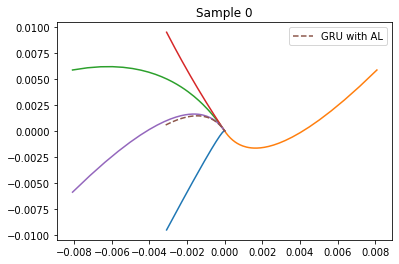

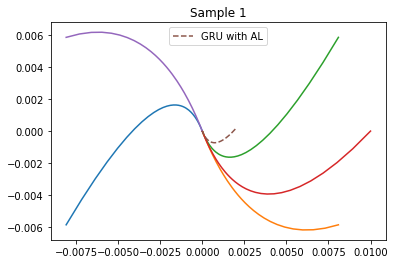

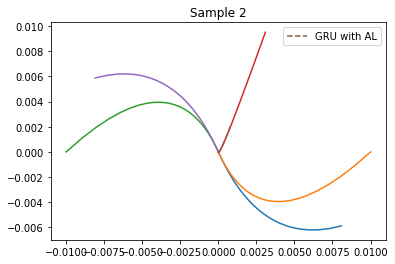

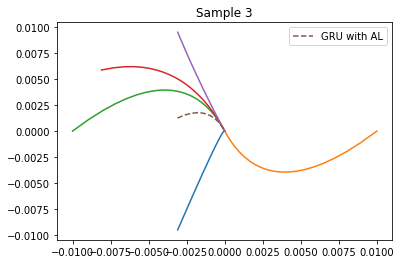

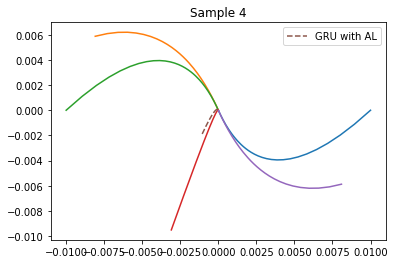

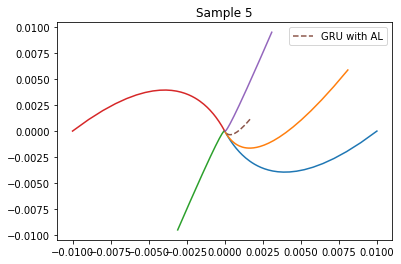

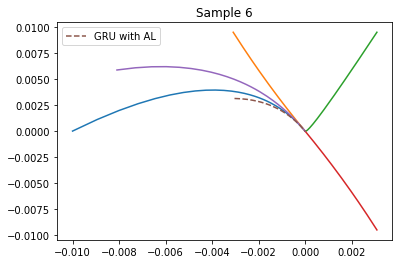

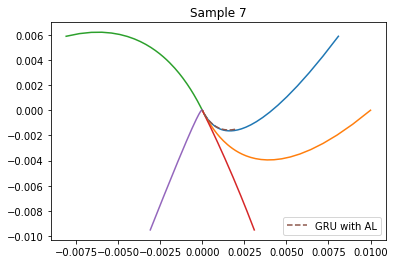

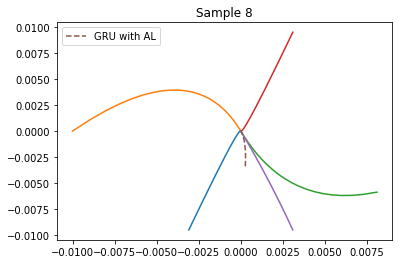

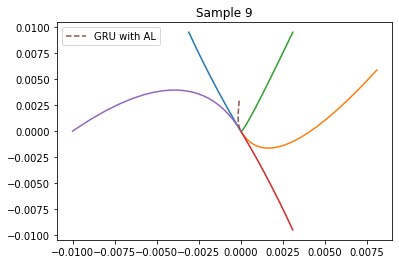

In [9]:
U = np.array([[0.1, -0.1],[-1, 0]])
times = np.linspace(0, 500, 2000) 
for i in range(10):
    sample = random.sample(range(len(x_inits)), 5)
    plot_alu_soln(x_inits, times, U, sample, title=f'Sample {i}')